# RESULTS DVS Gesture

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/'

device = 'cuda'

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
kfold_test = None
kfold_clust = 10
ts_batch_size = int(1e5)

dataset_name = 'gesture'
slicing_time_window = 3e6
only_first = True

trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=only_first)
print('--- Slicing dataset done ---')

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=only_first, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=only_first, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

Read metadata from disk.
Read metadata from disk.
--- Slicing dataset done ---
Read metadata from disk.
Read metadata from disk.
Read metadata from disk.
number of samples in the training set: 1077
number of samples in the testing set: 264


In [36]:
events, label = next(iter(testset))
print(events.shape)

(288123, 4)


## Initialization of the network

In [4]:
name = 'homeohots_pool'
homeo = True
timestr = '2023-05-23'
dataset_name = 'gesture'

Rz = [2, 2]
N_neuronz = [32, 64]
tauz = [5e3*2, 5e3*N_neuronz[0]]#/(2*Rz[0]+1)**2]
pooling_coef = [2, 2]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, pooling_coef = pooling_coef, record_path=record_path)

initial_name = hots.name

hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False, pooling_coef = pooling_coef, record_path=record_path)

initial_name_nohomeo = hots_nohomeo.name

../Records/networks/2023-05-23_gesture_homeohots_pool_True_[32, 64]_[10000.0, 160000.0]_[2, 2].pkl
../Records/networks/2023-05-23_gesture_homeohots_pool_False_[32, 64]_[10000.0, 160000.0]_[2, 2].pkl


## Unsupervised clustering

In [5]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = record_path+'networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)

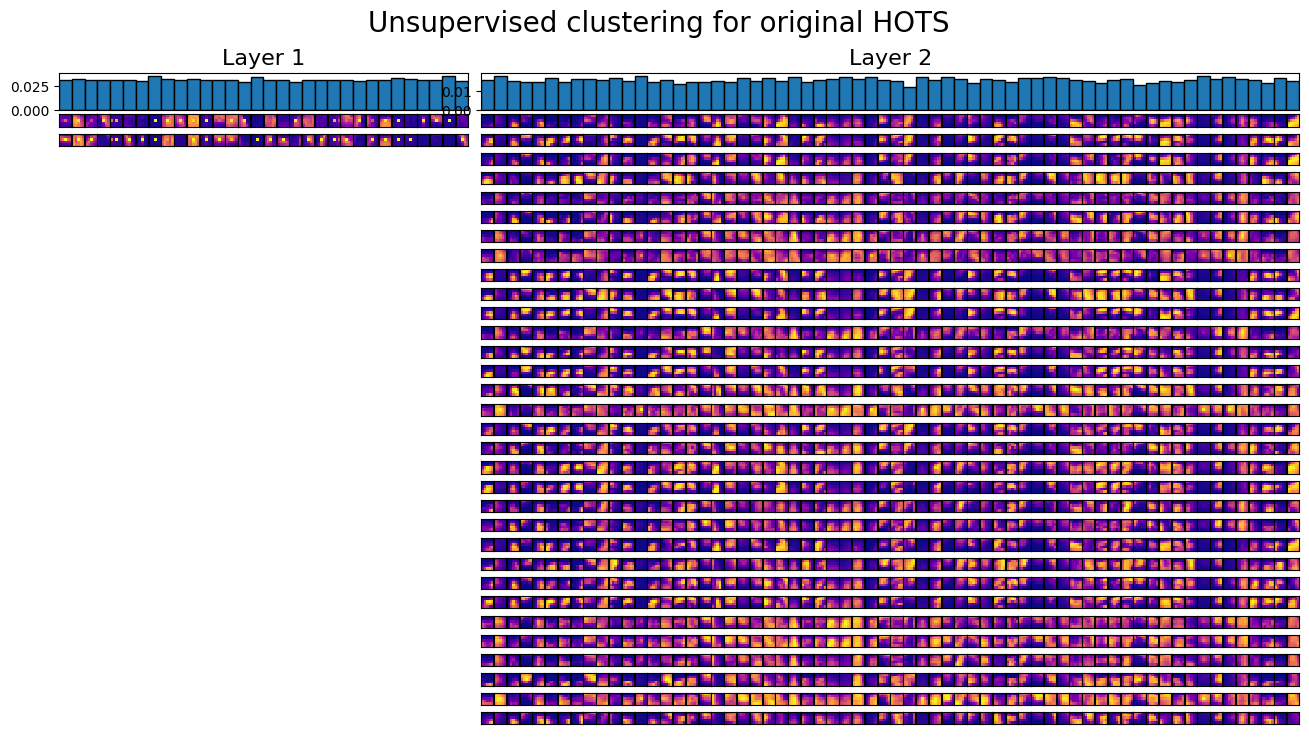

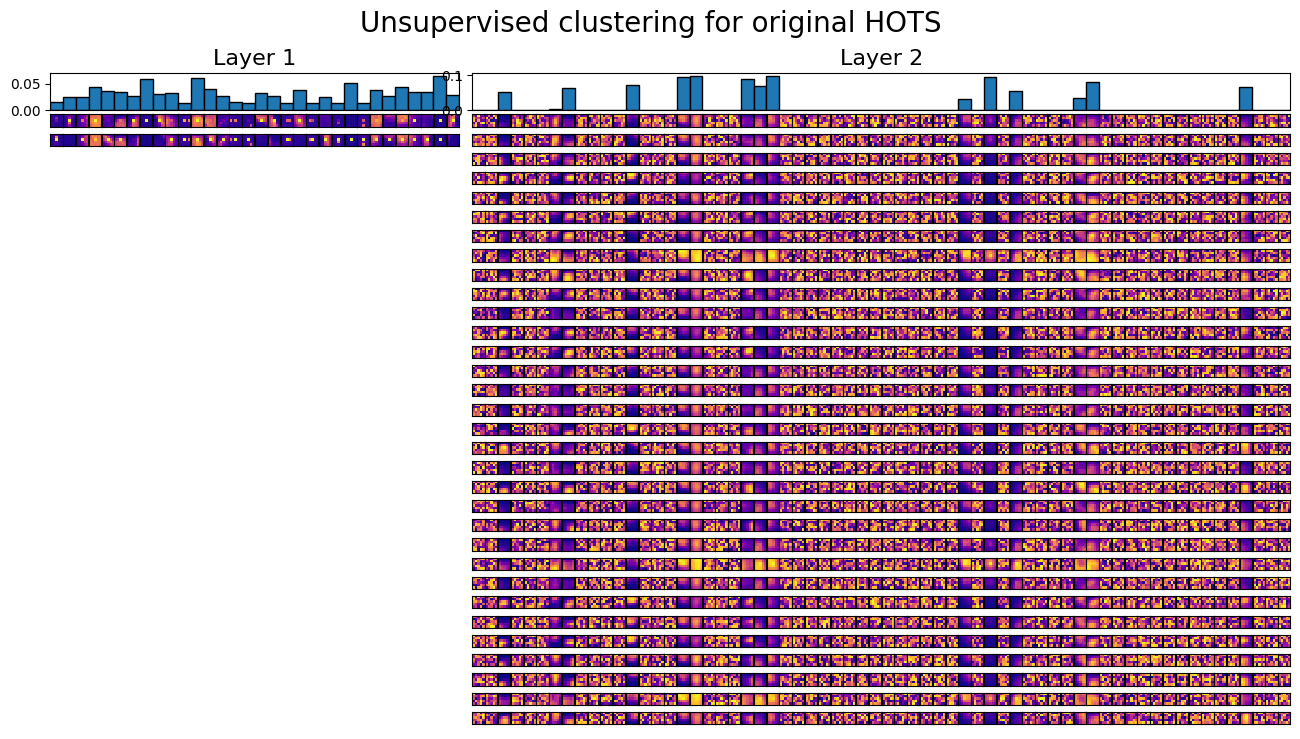

In [6]:
hots.plotlayers();
hots_nohomeo.plotlayers();
#hots.plotlearning();

## Training of the classification layer

In [7]:
jitter = (None, None)

hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=False, verbose=False)

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=True, verbose=False)
hots_nohomeo.coding(testloader, testset.ordering, testset.classes, filtering_threshold = filtering_threshold, training=False, jitter=jitter, verbose=False)

In [8]:
num_workers = 0
N_output_neurons = N_neuronz[-1]
learning_rate = 0.00005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
sensor_size = (trainset.sensor_size[0]//25+1,trainset.sensor_size[1]//25+1, N_output_neurons)
tau_cla = int(1e6)#5e3*N_neuronz[-1]
drop_proba = .95

ts_size = None#(31,31)
ts_batch_size = int(2e5)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
print(model_path)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)
kfold_mlr = None

trainset_output = HOTS_Dataset(train_path, sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([type_transform]))
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, sensor_size, trainset.ordering, len(trainset.classes), ts_size = ts_size, ts_batch_size = ts_batch_size, drop_proba = drop_proba)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

../Records/networks/2023-05-23_gesture_homeohots_pool_True_[32, 64]_[10000.0, 160000.0]_[2, 2]_conv_1000000_5e-05_(0.9, 0.999)_33_0.95_(None, None).pkl


## Online Inference (Figure 4-(b))

In [9]:
score = 0.8295454545454546
score_nohomeo = 0.7045454545454546

Number of chance decisions: 0
90th quantile for number of events: 344719.30000000005
Mean accuracy: 85.7%
Last accuracy: 87.9%
Highest probability accuracy: 89.8%


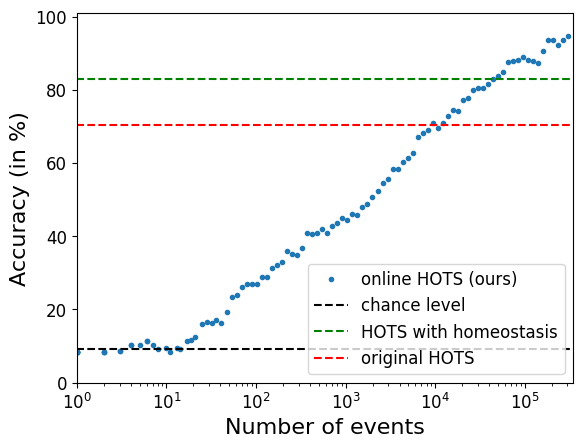

In [10]:
mlr_threshold = None
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, ts_batch_size = int(ts_batch_size/2), online_plot = True, save_likelihood = False)

Number of chance decisions: 4
90th quantile for number of events: 344719.30000000005
Mean accuracy: 87.2%
Last accuracy: 81.8%
Highest probability accuracy: 89.8%


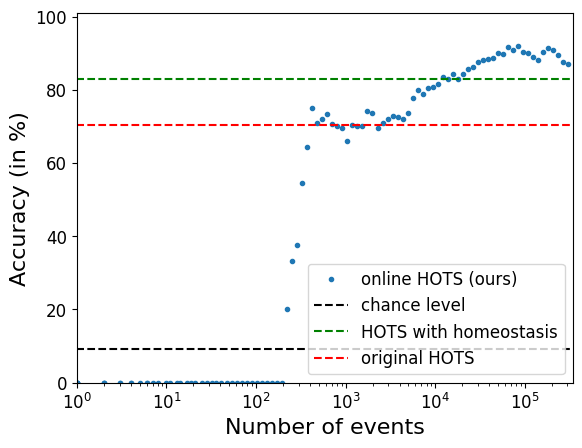

In [11]:
mlr_threshold = .5
onlinac_thres, best_probability_thres, meanac_thres, lastac_thres = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, ts_batch_size = int(ts_batch_size/2), online_plot = True, save_likelihood = False)

In [12]:
onlinac_thres[onlinac_thres==0] = np.nan

/tmp/ipykernel_3134550/1241649777.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']*5);


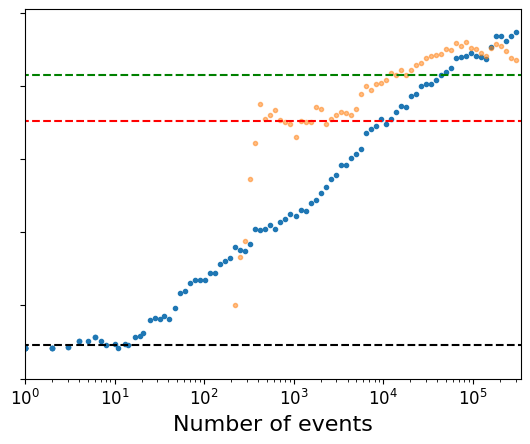

In [13]:
import matplotlib.pyplot as plt

event_90th = 344719
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with \nhomeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
#ax.set_ylabel('Accuracy (in %)', fontsize=16);
#ax.legend(fontsize=12, loc='upper left');
    #printfig(fig, figure_name)
ax.set_yticklabels(['']*5);

In [14]:
name = 'gesture_online.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

## Robustness to spatial jitter (Figure 5-(b)-(up))

In [27]:
kfold_jitter = 4
nb_trials = 10
nb_points = 20
mlr_threshold = .5
ts_batch_size = int(1e5)

trainset_output_jitter = HOTS_Dataset(train_path, sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

In [1]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = False, ts_batch_size = ts_batch_size, device = device, slicing_time_window = slicing_time_window, verbose = True);

NameError: name 'initial_name' is not defined

## Robustness to temporal jitter (Figure 5-(b)-(down))

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = False, slicing_time_window = slicing_time_window, device = device, verbose = True);